# FINA4335 Final Project

Shrey Patel, Aarshiya Sachdeva, Evan Daniels, Rider Bishop

In [158]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Part 1: Constructing the trading strategies

## Task 1: Constructing Trading Strategies

In [159]:
# import data

DAILY_STOCK_RETURNS_FILE_PATH = 'Daily_Stock_Returns.csv'
MONTHLY_STOCK_RETURNS_FILE_PATH = 'Monthly_Stock_Returns.csv'
US_POLICY_UNCERTAINTY_DATA = '/content/US_Policy_Uncertainty_Data.csv'

df_daily_stock_returns = pd.read_csv(DAILY_STOCK_RETURNS_FILE_PATH)
df_monthly_stock_returns = pd.read_csv(MONTHLY_STOCK_RETURNS_FILE_PATH)
df_us_policy_uncertainty_data = pd.read_csv(US_POLICY_UNCERTAINTY_DATA)
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', dt.datetime(1980, 1, 1), dt.datetime(2023, 12, 31))[0][['Mkt-RF','RF','SMB','HML']].div(100)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

<ipython-input-159-1c718ed5bc8c>:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_daily_stock_returns = pd.read_csv(DAILY_STOCK_RETURNS_FILE_PATH)
<ipython-input-159-1c718ed5bc8c>:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', dt.datetime(1980, 1, 1), dt.datetime(2023, 12, 31))[0][['Mkt-RF','RF','SMB','HML']].div(100)
<ipython-input-159-1c718ed5bc8c>:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  rf = web.DataReader('F-F_Research_Data_Factors','famafrench', dt.datetime(1980, 1, 1), dt.datetime(2023, 12, 31))[0][['Mkt-RF','RF','SMB','HML']].div(100)


In [160]:
# data cleaning

# Monthly Returns

df_monthly_stock_returns['date'] = pd.to_datetime(df_monthly_stock_returns['date']) + MonthEnd(0)
df_monthly_stock_returns.dropna(inplace=True)
df_monthly_stock_returns.sort_values(['permno','date'], inplace=True)

# Daily Returns

df_daily_stock_returns['date'] = pd.to_datetime(df_daily_stock_returns['date'])
df_daily_stock_returns.dropna(inplace=True)
df_daily_stock_returns.sort_values(['permno','date'], inplace=True)

df_daily_stock_returns['ret'] = pd.to_numeric(df_daily_stock_returns['ret'], errors='coerce')
df_daily_stock_returns = df_daily_stock_returns.dropna()

# Uncertainty
df_us_policy_uncertainty_data['Date'] = pd.to_datetime(df_us_policy_uncertainty_data[['Year','Month']].assign(DAY=1))
df_us_policy_uncertainty_data = df_us_policy_uncertainty_data.set_index('Date').resample('M').last()
df_us_policy_uncertainty_data = df_us_policy_uncertainty_data.drop(columns = ['Year','Month'])
df_us_policy_uncertainty_data.dropna(inplace=True)

# Fama French / Risk-Free Rate
# Convert the index to timestamps representing the end of each time period, and normalize them to remove the time component
rf.index = rf.index.to_timestamp(how='end').normalize()

<ipython-input-160-9989788caced>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_monthly_stock_returns['date'] = pd.to_datetime(df_monthly_stock_returns['date']) + MonthEnd(0)
<ipython-input-160-9989788caced>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_daily_stock_returns['date'] = pd.to_datetime(df_daily_stock_returns['date'])


In [161]:
# Function for calculating time series momentum based on monthly stock returns
def time_series_momentum():
    global df_monthly_stock_returns  # Accessing the global variable for monthly stock returns
    
    window = 6  # Rolling window size
    
    # Creating a temporary copy of monthly stock returns DataFrame and sorting it by permno and date
    df_monthly_stock_returns_temp = df_monthly_stock_returns.copy().sort_values(by=['permno', 'date'])
    
    # Calculating rolling average of returns over a specified window for each permno
    df_monthly_stock_returns_temp['rolling_avg'] = df_monthly_stock_returns_temp.groupby('permno')['ret'].rolling(window).apply(lambda x: x.add(1).prod()).sub(1).shift(1).reset_index(level=0, drop=True)
    
    # Renaming the 'ret' column to 'ret6' for clarity
    df_monthly_stock_returns_temp.rename(columns={'ret': 'ret6'}, inplace=True)
    
    # Generating positions based on the sign of rolling average
    df_monthly_stock_returns_temp['position'] = np.where(df_monthly_stock_returns_temp['rolling_avg'] > 0, 1, -1)
    
    # Handling NaN values in rolling average and setting corresponding positions to 0
    temporary = df_monthly_stock_returns_temp['rolling_avg'].notnull() & df_monthly_stock_returns_temp['rolling_avg'].shift(-1).isnull()
    df_monthly_stock_returns_temp.loc[temporary, 'rolling_avg'] = np.nan
    df_monthly_stock_returns_temp.loc[df_monthly_stock_returns_temp['rolling_avg'].isna(), 'position'] = 0
    
    # Returning DataFrame with selected columns and setting date and permno as index
    return df_monthly_stock_returns_temp[['date', 'permno', 'position', 'rolling_avg']].set_index(['date', 'permno'])

# Function for calculating cross-sectional echo strategy based on monthly stock returns
def cross_sectional_echo():
    global df_monthly_stock_returns  # Accessing the global variable for monthly stock returns
    
    # Creating a temporary copy of monthly stock returns DataFrame and sorting it by permno and date
    df_monthly_stock_returns_temp = df_monthly_stock_returns.copy().sort_values(by=['permno', 'date'])
    
    # Calculating intermediate past horizon returns over a rolling window for each permno
    intermediate_past_horizon = df_monthly_stock_returns.groupby('permno')['ret'].rolling(window=7).apply(lambda x: x.add(1).prod()).sub(1)
    
    # Assigning intermediate past horizon returns to DataFrame
    intermediate_past_horizon = df_monthly_stock_returns_temp.assign(intermediate_past_horizon=intermediate_past_horizon.values)[['date', 'permno', 'intermediate_past_horizon']]
    
    # Adding 6 months to the date to get the month for comparison
    intermediate_past_horizon['month'] = intermediate_past_horizon['date'] + pd.DateOffset(months=6)
    intermediate_past_horizon['month'] = intermediate_past_horizon['month'].dt.to_period('M')
    
    # Adding a 'month' column to the temporary DataFrame for merging
    df_monthly_stock_returns_temp['month'] = df_monthly_stock_returns_temp['date'].dt.to_period('M')
    
    # Dropping rows with NaN values
    intermediate_past_horizon.dropna(inplace=True)
    
    # Merging temporary DataFrame with intermediate past horizon DataFrame based on permno and month
    df_monthly_stock_returns_temp = pd.merge(df_monthly_stock_returns_temp, intermediate_past_horizon, on=['permno', 'month'], how='left')
    df_monthly_stock_returns_temp.drop(columns=['date_y', 'month'], inplace=True)
    df_monthly_stock_returns_temp = df_monthly_stock_returns_temp.rename(columns={'date_x': 'date'})
    
    # Calculating percentile rank of intermediate past horizon returns for each date
    df_monthly_stock_returns_temp['monthly_percentile'] = df_monthly_stock_returns_temp.groupby('date')['intermediate_past_horizon'].rank(pct=True)
    
    # Generating positions based on monthly percentile ranks: 1 for top 10%, -1 for bottom 10%, 0 otherwise
    df_monthly_stock_returns_temp['position'] = np.where(df_monthly_stock_returns_temp['monthly_percentile'] >= 0.9, 1, np.where(df_monthly_stock_returns_temp['monthly_percentile'] <= 0.1, -1, 0))
    
    # Returning DataFrame with selected columns and setting date and permno as index
    return df_monthly_stock_returns_temp[['date', 'permno', 'position']].set_index(['date', 'permno'])

# Function for calculating low volatility strategy based on daily stock returns
def low_volatility():
    global df_daily_stock_returns  # Accessing the global variable for daily stock returns
    
    # Creating a temporary copy of daily stock returns DataFrame and sorting it by permno and date
    df_daily_stock_returns_temp = df_daily_stock_returns.copy().sort_values(by=['permno', 'date'])
    
    # Calculating monthly stock volatility for each permno
    monthly_stock_volatility = df_daily_stock_returns_temp.groupby('permno').resample('M', on='date').std()
    
    # Calculating percentile rank of monthly stock volatility for each date
    monthly_stock_volatility['monthly_ranking'] = monthly_stock_volatility.groupby('date')['ret'].transform(lambda x: x.rank(pct=True))
    
    # Generating positions based on monthly volatility ranks: -1 for top 10%, 1 for bottom 10%, 0 otherwise
    monthly_stock_volatility['position'] = np.where(monthly_stock_volatility['monthly_ranking'] >= 0.9, -1, np.where(monthly_stock_volatility['monthly_ranking'] <= 0.1, 1, 0)).astype(int)
    
    # Dropping unnecessary columns
    monthly_stock_volatility.drop(columns=['ret', 'monthly_ranking', 'permno'], inplace=True)
    
    # Resetting index for further operations
    monthly_stock_volatility.reset_index(inplace=True)
    
    # Adding 1 month to the date to align positions for the next month
    monthly_stock_volatility['date'] = monthly_stock_volatility['date'] + pd.DateOffset(months=1)
    
    # Setting date and permno as index
    monthly_stock_volatility.set_index(['date', 'permno'], inplace=True)
    
    # Returning DataFrame with selected columns
    return monthly_stock_volatility[['position']]


In [162]:
time_series = time_series_momentum()

cross_sectional = cross_sectional_echo()

low_vol = low_volatility()

In [163]:
time_series.rename(columns={'position': 'position_time_series'}, inplace=True)
cross_sectional.rename(columns={'position': 'position_cross_sectional'}, inplace=True)
low_vol.rename(columns={'position': 'position_low_volatility'}, inplace=True)

df_monthly_stock_returns.set_index(['date', 'permno'], inplace=True)

In [164]:
# Merging time series momentum positions with monthly stock returns
df_monthly_positions = pd.merge(df_monthly_stock_returns, time_series, how='left', left_index=True, right_index=True)

# Merging cross-sectional echo positions with previously merged DataFrame
df_monthly_positions = pd.merge(df_monthly_positions, cross_sectional, how='left', left_index=True, right_index=True)

# Merging low volatility positions with previously merged DataFrame
df_monthly_positions = pd.merge(df_monthly_positions, low_vol, how='left', left_index=True, right_index=True)

# Filling NaN values with 0
df_monthly_positions.fillna(0, inplace=True)

# Converting 'position_low_volatility' column to int64 data type
df_monthly_positions['position_low_volatility'] = df_monthly_positions['position_low_volatility'].astype('int64')


In [165]:
# Calculating time series momentum strategy returns
df_monthly_positions['time_series_return'] = df_monthly_positions['position_time_series'] * df_monthly_positions['ret']

# Calculating cross-sectional echo strategy returns
df_monthly_positions['cross_sectional_return'] = df_monthly_positions['position_cross_sectional'] * df_monthly_positions['ret']

# Calculating low volatility strategy returns
df_monthly_positions['low_volatility_return'] = df_monthly_positions['position_low_volatility'] * df_monthly_positions['ret']

# Resetting the index of the DataFrame
df_monthly_positions.reset_index(inplace=True)



In [166]:
# Extracting the 'date' column for the strategy returns DataFrame
strategy_returns = df_monthly_positions[['date']]

# Calculating the mean returns for each strategy grouped by date
strategy_returns = df_monthly_positions.groupby('date').mean()[['time_series_return', 'cross_sectional_return', 'low_volatility_return']]

# Calculating cumulative returns for each strategy by adding 1 and taking the cumulative product
strategy_cumulative_returns = strategy_returns.add(1).cumprod()


Text(0.5, 1.0, 'Value of $1 Investment using Time Series, Cross Sectional, and Low Volatility Strategies between 1980 and 2023')

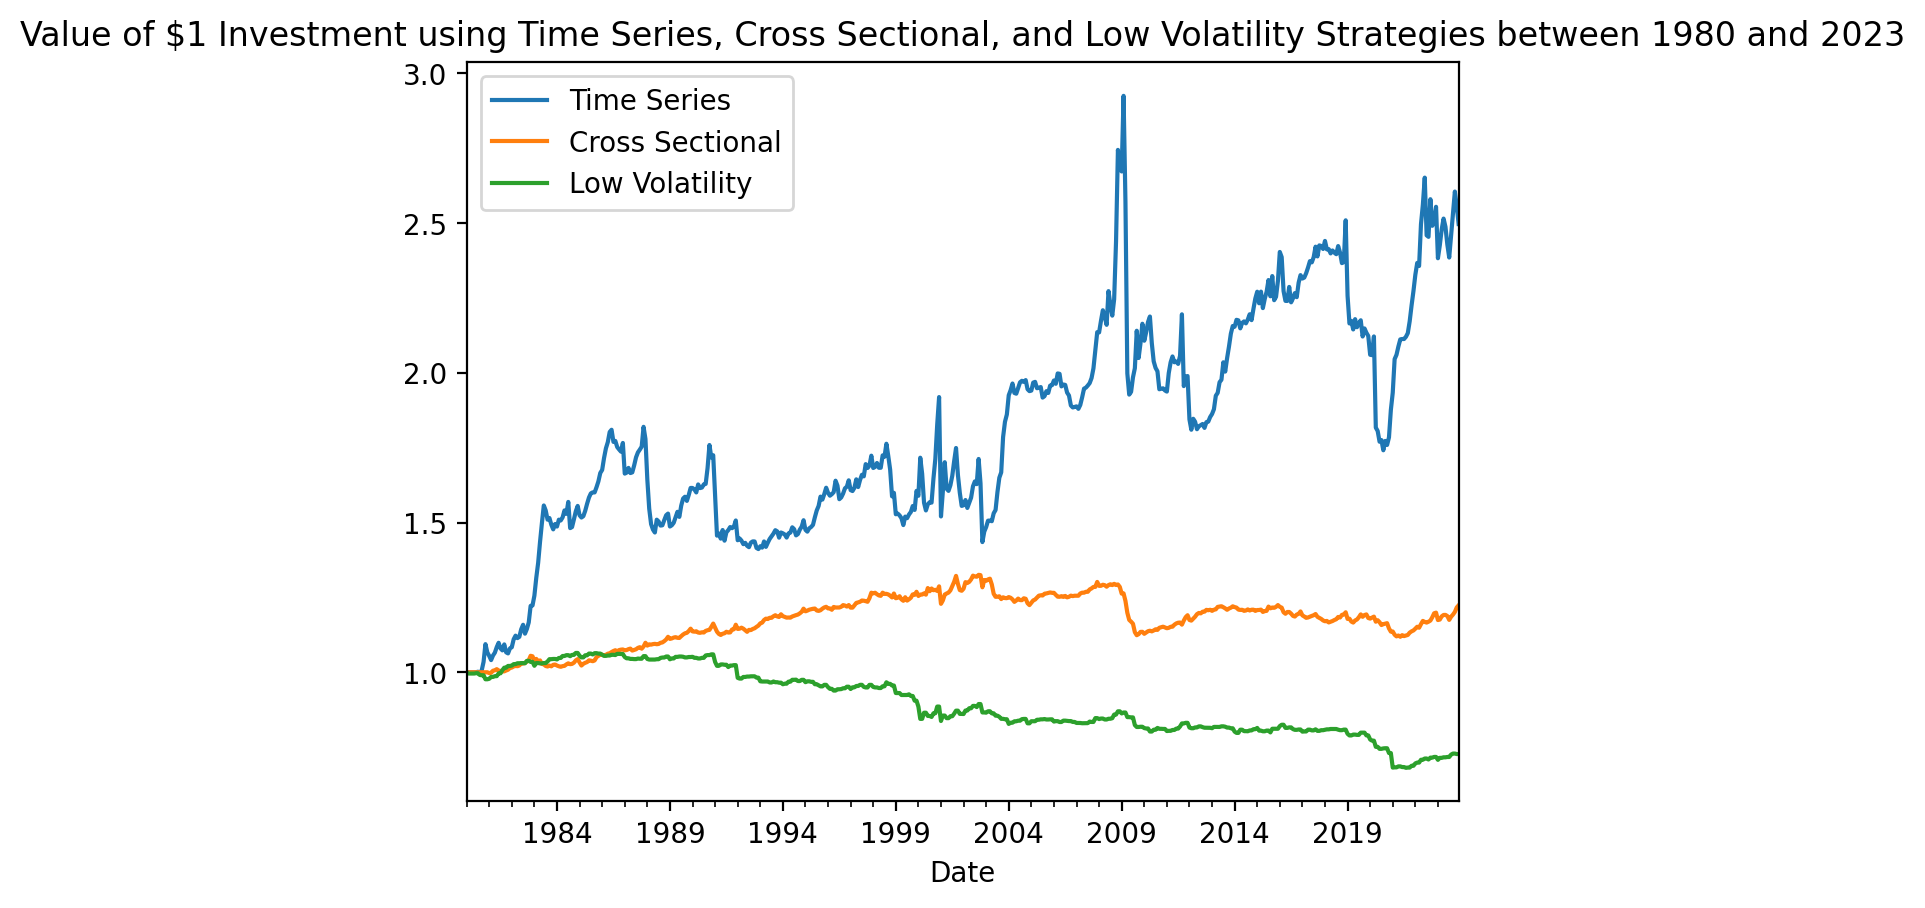

In [167]:
new_names = {'time_series_return': 'Time Series', 'cross_sectional_return': "Cross Sectional", 'low_volatility_return': 'Low Volatility'}

strategy_cumulative_returns.rename(columns=new_names).plot()
plt.xlabel('Date')
plt.title('Value of $1 Investment using Time Series, Cross Sectional, and Low Volatility Strategies between 1980 and 2023')

## Task 2: Performance Measures for Each strategy

In [168]:
performance_measures = ['Average Monthly Return', 'Monthly Standard Deviation', 'Annualized Sharpe Ratio',
                        'Maximum Drawdown', 'VaR(95%) - Historical', 'VaR(95%) - Parametric',
                        'CVar(95%) - Historical', 'Beta - CAPM', 'Alpha - FamaFrench 3']

performance_measures_table = pd.DataFrame(columns=performance_measures, index=['Time Series', 'Cross Sectional', 'Low Volatility'])
performance_measures_table.index.name = 'Strategy'

In [1]:
def find_average_monthly_return():
    time_series_average = strategy_returns['time_series_return'].mean()
    cross_sectional_average = strategy_returns['cross_sectional_return'].mean()
    low_volatility_average = strategy_returns['low_volatility_return'].mean()
    return [time_series_average, cross_sectional_average, low_volatility_average]

def find_monthly_standard_deviation():
    time_series_std = strategy_returns['time_series_return'].std()
    cross_sectional_std = strategy_returns['cross_sectional_return'].std()
    low_volatility_std = strategy_returns['low_volatility_return'].std()
    return [time_series_std, cross_sectional_std, low_volatility_std]

def find_annualized_sharpe_ratio():
    time_series_ann_sharpe = ((strategy_returns['time_series_return'] - rf['RF']).mean()*12) / ((strategy_returns['time_series_return'] - rf['RF']).std()*np.sqrt(12))
    cross_sectional_ann_sharpe = ((strategy_returns['cross_sectional_return'] - rf['RF']).mean()*12) / ((strategy_returns['cross_sectional_return'] - rf['RF']).std()*np.sqrt(12))
    low_volatility_ann_sharpe = ((strategy_returns['low_volatility_return'] - rf['RF']).mean()*12) / ((strategy_returns['low_volatility_return'] - rf['RF']).std()*np.sqrt(12))
    return [time_series_ann_sharpe, cross_sectional_ann_sharpe, low_volatility_ann_sharpe]

def find_maximum_drawdown():
    # project instructions don't specify all-time or some rolling lookback period for the drawdown calculation, default to all-time
    window = strategy_cumulative_returns.shape[0]
    Rolling_Peak = strategy_cumulative_returns.rolling(window, min_periods=1).max()
    Monthly_Drawdown = strategy_cumulative_returns/Rolling_Peak - 1.0
    Max_Monthly_Drawdown = Monthly_Drawdown.rolling(window, min_periods=1).min()
    return [Max_Monthly_Drawdown['time_series_return'].min(),Max_Monthly_Drawdown['cross_sectional_return'].min(),Max_Monthly_Drawdown['low_volatility_return'].min()]

def find_var_historical():
    # VaR represents the maximum potential loss at a specified confidence level
    confidence = 0.95

    time_series_hVaR = np.percentile(strategy_returns['time_series_return'].dropna(), 100 * (1-confidence))
    cross_sectional_hVaR = np.percentile(strategy_returns['cross_sectional_return'].dropna(), 100 * (1-confidence))
    low_volatility_hVaR = np.percentile(strategy_returns['low_volatility_return'].dropna(), 100 * (1-confidence))
    return [time_series_hVaR, cross_sectional_hVaR, low_volatility_hVaR]

def find_var_parametric():
    # Parametric VaR estimates potential losses based on a statistical model, assuming a normal distribution of returns
    confidence = 0.95
    norm = scipy.stats.norm

    time_series_pVaR = norm.ppf(1-confidence, strategy_returns['time_series_return'].mean(), strategy_returns['time_series_return'].std())
    cross_sectional_pVaR = norm.ppf(1-confidence, strategy_returns['cross_sectional_return'].mean(), strategy_returns['cross_sectional_return'].std())
    low_volatility_pVaR = norm.ppf(1-confidence, strategy_returns['low_volatility_return'].mean(), strategy_returns['low_volatility_return'].std())
    return [time_series_pVaR, cross_sectional_pVaR, low_volatility_pVaR]

def find_cvar():
    # CVaR represents the expected loss beyond VaR at a specified confidence level
    confidence = 0.95

    time_series_CVaR = np.mean(strategy_returns['time_series_return'].dropna()[strategy_returns['time_series_return'].dropna()<np.percentile(strategy_returns['time_series_return'].dropna(), 100 * (1-confidence))])
    cross_sectional_CVaR = np.mean(strategy_returns['cross_sectional_return'].dropna()[strategy_returns['cross_sectional_return'].dropna()<np.percentile(strategy_returns['cross_sectional_return'].dropna(), 100 * (1-confidence))])
    low_volatility_CVaR = np.mean(strategy_returns['low_volatility_return'].dropna()[strategy_returns['low_volatility_return'].dropna()<np.percentile(strategy_returns['low_volatility_return'].dropna(), 100 * (1-confidence))])
    return [time_series_CVaR, cross_sectional_CVaR, low_volatility_CVaR]

def find_beta():
    capm_temp = rf.copy()
    capm_temp['time_series-RF'] = strategy_returns['time_series_return'] - rf['RF']
    capm_temp['cross_sectional-RF'] = strategy_returns['cross_sectional_return'] - rf['RF']
    capm_temp['low_volatility-RF'] = strategy_returns['low_volatility_return'] - rf['RF']

    time_series_cov = capm_temp[['time_series-RF','Mkt-RF']].cov()
    cross_sectional_cov = capm_temp[['cross_sectional-RF','Mkt-RF']].cov()
    low_volatility_cov = capm_temp[['low_volatility-RF','Mkt-RF']].cov()

    time_series_beta =  time_series_cov.loc['time_series-RF','Mkt-RF']/ time_series_cov.loc['Mkt-RF','Mkt-RF']
    cross_sectional_beta =  cross_sectional_cov.loc['cross_sectional-RF','Mkt-RF']/ cross_sectional_cov.loc['Mkt-RF','Mkt-RF']
    low_volatility_beta =  low_volatility_cov.loc['low_volatility-RF','Mkt-RF']/ low_volatility_cov.loc['Mkt-RF','Mkt-RF']
    return [time_series_beta, cross_sectional_beta, low_volatility_beta]

def find_alpha():
    ff3_temp = rf.copy()
    ff3_temp['time_series-RF'] = strategy_returns['time_series_return'] - rf['RF']
    ff3_temp['cross_sectional-RF'] = strategy_returns['cross_sectional_return'] - rf['RF']
    ff3_temp['low_volatility-RF'] = strategy_returns['low_volatility_return'] - rf['RF']

    X = sm.add_constant(ff3_temp[['Mkt-RF','SMB','HML']])

    time_series_ff3 = sm.OLS(ff3_temp['time_series-RF'], X, missing = 'drop').fit()
    cross_sectional_ff3 = sm.OLS(ff3_temp['cross_sectional-RF'], X, missing = 'drop').fit()
    low_volatility_ff3 = sm.OLS(ff3_temp['low_volatility-RF'], X, missing = 'drop').fit()
    return [time_series_ff3.params.iloc[0], cross_sectional_ff3.params.iloc[0], low_volatility_ff3.params.iloc[0]]

In [170]:
performance_measures_table['Average Monthly Return'] = find_average_monthly_return()
performance_measures_table['Monthly Standard Deviation'] = find_monthly_standard_deviation()
performance_measures_table['Annualized Sharpe Ratio'] = find_annualized_sharpe_ratio()
performance_measures_table['Maximum Drawdown'] = find_maximum_drawdown()
performance_measures_table['VaR(95%) - Historical'] = find_var_historical()
performance_measures_table['VaR(95%) - Parametric'] = find_var_parametric()
performance_measures_table['CVar(95%) - Historical'] = find_cvar()
performance_measures_table['Beta - CAPM'] = find_beta()
performance_measures_table['Alpha - FamaFrench 3'] = find_alpha()

In [171]:
performance_measures_table.head()

,Average Monthly Return,Monthly Standard Deviation,Annualized Sharpe Ratio,Maximum Drawdown,VaR(95%) - Historical,VaR(95%) - Parametric,CVar(95%) - Historical,Beta - CAPM,Alpha - FamaFrench 3
Strategy,,,,,,,,,
Time Series,0.002,0.029,-0.130,-0.405,-0.039,-0.046,-0.080,-0.206,0.000
Cross Sectional,0.000,0.006,-1.459,-0.156,-0.011,-0.010,-0.018,-0.016,-0.003
Low Volatility,-0.001,0.008,-1.686,-0.360,-0.012,-0.013,-0.023,-0.051,-0.004


##Task 3: Performance Evaluation


***Our Pick: Time Series***

All three strategies underperformed the risk-free rate during the sample period, as evidenced by the negative sharpe ratios. While sharpe ratio is a good way to measure performance of a fund, it lacks its usual value when the strategy underperforms the risk free rate as its absolute value can be increased not just by improving returns relative to risk taken, but decreasing underperformance.

While the Time Series strategy delivered the highest return, it was also substantially more volatile and had a higher VaR and worse Drawdown, we decided it is the best due to it being the only fund with a positive average monthly return.

Though the Low Volatility strategy delivered on it's promise of low volatility, it also delivered a negative excess and absolute return, which is another reason why we chose the Time Series strategy instead.

The Time Series strategy managed to deliver a positive return, along with higher volatility. While the return was weak compared to the risk free rate, it is the only fund that does not have a negative alpha and weakly correlated to the market (signifying diversification).


# Part 2: Improving the Strategies

## Task 4: Conditioning Strategies on Uncertainty Data

While capturing upside can be valueable, avoiding impairment of capital (drawdowns, negative vol) is more attractive. Avoiding losses both substantially improves the compounding of returns and reduces risk, so this is what we will pursue fist.

To improve the strategies with Economic Uncertainty data, there are two clear paths: conditioning the strategies themselves (i.e. double long bets during euphoria) or conditioning the implementation of the strategies (i.e. take strategy-indicated positions only when uncertainty is low).

The second option seems attractive, theoretically allowing the strategies to be turned off during market conditions where they perform poorly. This is what we will attempt first, by implementing a moving average crossover style strategy to stop trading when uncertainty is spiking.

Text(0, 0.5, 'Uncertainty Index')

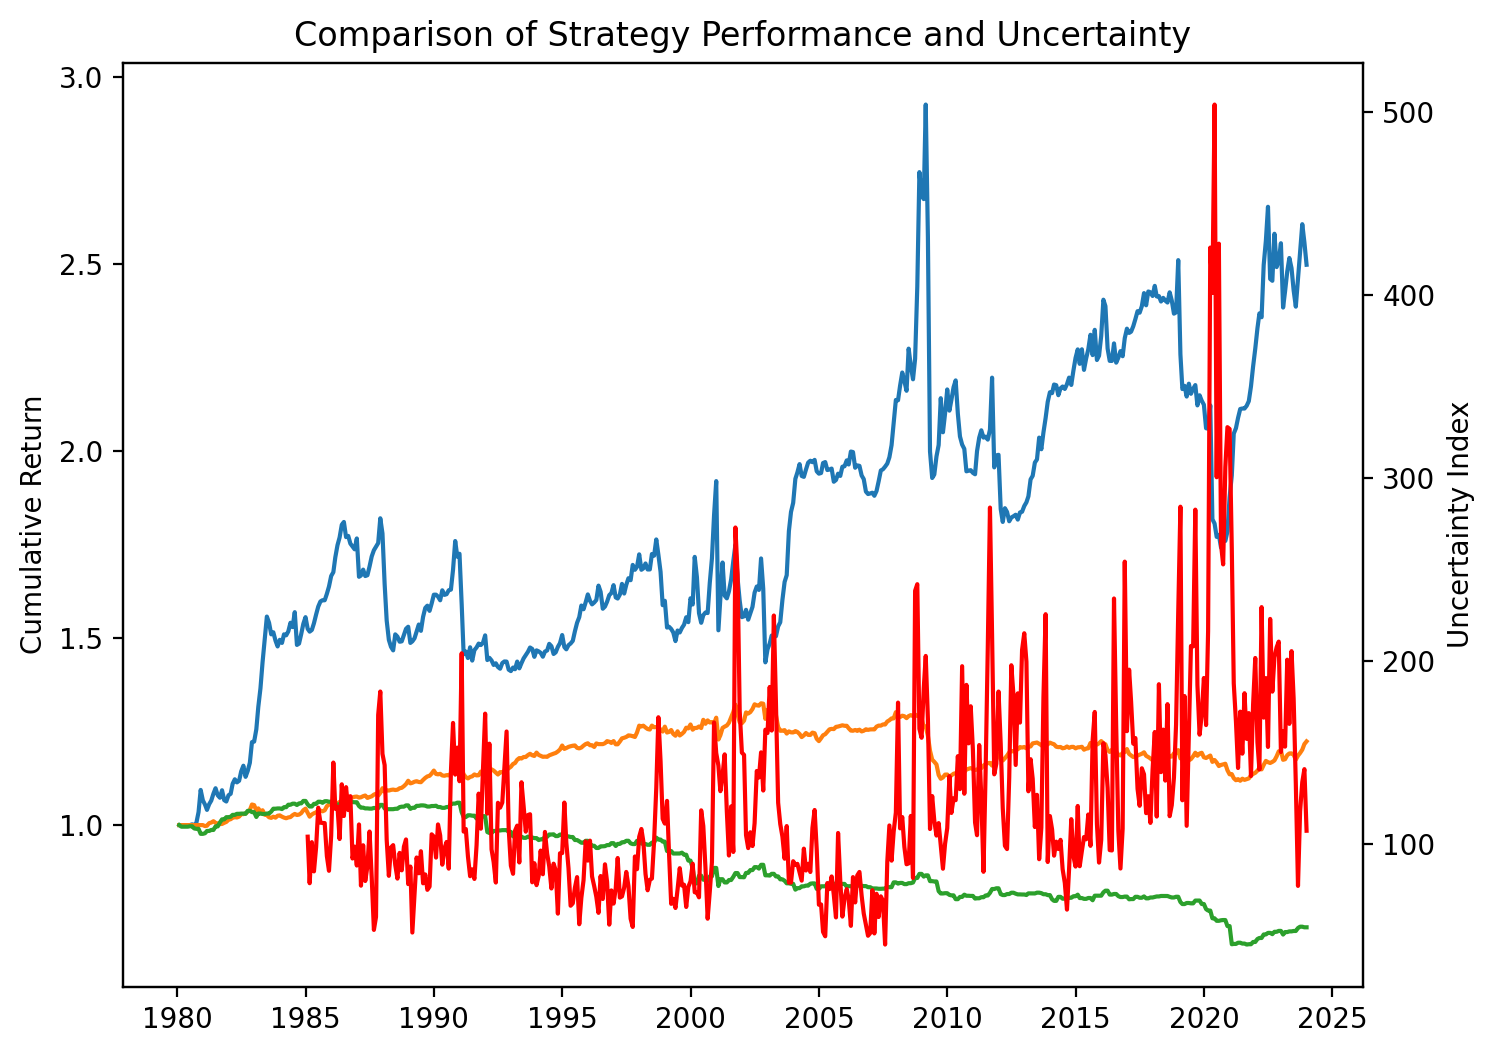

In [172]:
strategy_cumulative_and_uncertainty = strategy_cumulative_returns.join(df_us_policy_uncertainty_data)
figure1 = plt.figure(figsize = (8,6))
ax_returns = figure1.add_subplot()
ax_returns.plot(strategy_cumulative_and_uncertainty[['time_series_return', 'cross_sectional_return', 'low_volatility_return']])
ax_uncertainty = ax_returns.twinx()
ax_uncertainty.plot(strategy_cumulative_and_uncertainty['News_Based_Policy_Uncert_Index'], color = 'red')
ax_returns.set_ylabel('Cumulative Return'), ax_returns.set_title('Comparison of Strategy Performance and Uncertainty')
ax_uncertainty.set_ylabel('Uncertainty Index')

In [173]:
# create a new position tracker, deciding whether to keep strategy active or sit in cash each month
# in months. 2 seems to be the magic short window, but can optimize further
short_window = 2
long_window = 36

# risk on / strategy active = 1, risk off / cash = 0. Default on, including 1980-1985 where there is no uncertainty data
crossover_overlay = pd.DataFrame(index = strategy_returns.index)
crossover_overlay['SMA_short'] = df_us_policy_uncertainty_data['News_Based_Policy_Uncert_Index'].rolling(short_window).mean()
crossover_overlay['SMA_long'] = df_us_policy_uncertainty_data['News_Based_Policy_Uncert_Index'].rolling(long_window, min_periods=1).mean()
crossover_overlay['positions'] = np.select(
    condlist=[crossover_overlay['SMA_short'] > crossover_overlay['SMA_long']],
    choicelist=[0],
    default=1)

In [174]:
# Creating a copy of the strategy returns DataFrame for improved performance calculation
improved_performance = strategy_returns.copy()

# Multiplying the returns of each strategy by the corresponding positions from crossover_overlay
improved_performance['time_series_return'] = improved_performance['time_series_return'] * crossover_overlay['positions']
improved_performance['cross_sectional_return'] = improved_performance['cross_sectional_return'] * crossover_overlay['positions']
improved_performance['low_volatility_return'] = improved_performance['low_volatility_return'] * crossover_overlay['positions']

# Calculating cumulative performance for the improved strategy by adding 1 and taking the cumulative product
improved_cumulative_performance = improved_performance.add(1).cumprod()


## Task 5: Improved Strategy Risk and Performance Metrics

In [175]:
# ensure that the order of the 3 values that is returned is Time Series, Cross Sectional, and then Low Volatility

def find_improved_average_monthly_return():
    improved_time_series_average = improved_performance['time_series_return'].mean()
    improved_cross_sectional_average = improved_performance['cross_sectional_return'].mean()
    improved_low_volatility_average = improved_performance['low_volatility_return'].mean()
    return [improved_time_series_average, improved_cross_sectional_average, improved_low_volatility_average]

def find_improved_monthly_standard_deviation():
    improved_time_series_std = improved_performance['time_series_return'].std()
    improved_cross_sectional_std = improved_performance['cross_sectional_return'].std()
    improved_low_volatility_std = improved_performance['low_volatility_return'].std()
    return [improved_time_series_std, improved_cross_sectional_std, improved_low_volatility_std]

def find_improved_annualized_sharpe_ratio():
    improved_time_series_ann_sharpe = ((improved_performance['time_series_return'] - rf['RF']).mean()*12) / ((improved_performance['time_series_return'] - rf['RF']).std()*np.sqrt(12))
    improved_cross_sectional_ann_sharpe = ((improved_performance['cross_sectional_return'] - rf['RF']).mean()*12) / ((improved_performance['cross_sectional_return'] - rf['RF']).std()*np.sqrt(12))
    improved_low_volatility_ann_sharpe = ((improved_performance['low_volatility_return'] - rf['RF']).mean()*12) / ((improved_performance['low_volatility_return'] - rf['RF']).std()*np.sqrt(12))
    return [improved_time_series_ann_sharpe, improved_cross_sectional_ann_sharpe, improved_low_volatility_ann_sharpe]

def find_improved_maximum_drawdown():
    # project instructions don't specify all-time or some rolling lookback period for the drawdown calculation, default to all-time
    window = improved_cumulative_performance.shape[0]

    improved_Rolling_Peak = improved_cumulative_performance.rolling(window, min_periods=1).max()
    improved_Monthly_Drawdown = improved_cumulative_performance/improved_Rolling_Peak - 1.0
    improved_Max_Monthly_Drawdown = improved_Monthly_Drawdown.rolling(window, min_periods=1).min()
    return [improved_Max_Monthly_Drawdown['time_series_return'].min(),improved_Max_Monthly_Drawdown['cross_sectional_return'].min(),improved_Max_Monthly_Drawdown['low_volatility_return'].min()]

def find_improved_var_historical():
    confidence = 0.95

    improved_time_series_hVaR = np.percentile(improved_performance['time_series_return'].dropna(), 100 * (1-confidence))
    improved_cross_sectional_hVaR = np.percentile(improved_performance['cross_sectional_return'].dropna(), 100 * (1-confidence))
    improved_low_volatility_hVaR = np.percentile(improved_performance['low_volatility_return'].dropna(), 100 * (1-confidence))
    return [improved_time_series_hVaR, improved_cross_sectional_hVaR, improved_low_volatility_hVaR]

def find_improved_var_parametric():
    confidence = 0.95
    norm = scipy.stats.norm

    improved_time_series_pVaR = norm.ppf(1-confidence, improved_performance['time_series_return'].mean(), improved_performance['time_series_return'].std())
    improved_cross_sectional_pVaR = norm.ppf(1-confidence, improved_performance['cross_sectional_return'].mean(), improved_performance['cross_sectional_return'].std())
    improved_low_volatility_pVaR = norm.ppf(1-confidence, improved_performance['low_volatility_return'].mean(), improved_performance['low_volatility_return'].std())
    return [improved_time_series_pVaR, improved_cross_sectional_pVaR, improved_low_volatility_pVaR]

def find_improved_cvar():
    confidence = 0.95

    improved_time_series_CVaR = np.mean(improved_performance['time_series_return'].dropna()[improved_performance['time_series_return'].dropna()<np.percentile(improved_performance['time_series_return'].dropna(), 100 * (1-confidence))])
    improved_cross_sectional_CVaR = np.mean(improved_performance['cross_sectional_return'].dropna()[improved_performance['cross_sectional_return'].dropna()<np.percentile(improved_performance['cross_sectional_return'].dropna(), 100 * (1-confidence))])
    improved_low_volatility_CVaR = np.mean(improved_performance['low_volatility_return'].dropna()[improved_performance['low_volatility_return'].dropna()<np.percentile(improved_performance['low_volatility_return'].dropna(), 100 * (1-confidence))])
    return [improved_time_series_CVaR, improved_cross_sectional_CVaR, improved_low_volatility_CVaR]

def find_improved_beta():
    improved_capm_temp = rf.copy()
    improved_capm_temp['time_series-RF'] = improved_performance['time_series_return'] - rf['RF']
    improved_capm_temp['cross_sectional-RF'] = improved_performance['cross_sectional_return'] - rf['RF']
    improved_capm_temp['low_volatility-RF'] = improved_performance['low_volatility_return'] - rf['RF']

    improved_time_series_cov = improved_capm_temp[['time_series-RF','Mkt-RF']].cov()
    improved_cross_sectional_cov = improved_capm_temp[['cross_sectional-RF','Mkt-RF']].cov()
    improved_low_volatility_cov = improved_capm_temp[['low_volatility-RF','Mkt-RF']].cov()

    improved_time_series_beta =  improved_time_series_cov.loc['time_series-RF','Mkt-RF']/ improved_time_series_cov.loc['Mkt-RF','Mkt-RF']
    improved_cross_sectional_beta =  improved_cross_sectional_cov.loc['cross_sectional-RF','Mkt-RF']/ improved_cross_sectional_cov.loc['Mkt-RF','Mkt-RF']
    improved_low_volatility_beta =  improved_low_volatility_cov.loc['low_volatility-RF','Mkt-RF']/ improved_low_volatility_cov.loc['Mkt-RF','Mkt-RF']
    return [improved_time_series_beta, improved_cross_sectional_beta, improved_low_volatility_beta]

def find_improved_alpha():
    improved_ff3_temp = rf.copy()
    improved_ff3_temp['time_series-RF'] = improved_performance['time_series_return'] - rf['RF']
    improved_ff3_temp['cross_sectional-RF'] = improved_performance['cross_sectional_return'] - rf['RF']
    improved_ff3_temp['low_volatility-RF'] = improved_performance['low_volatility_return'] - rf['RF']

    X = sm.add_constant(improved_ff3_temp[['Mkt-RF','SMB','HML']])

    improved_time_series_ff3 = sm.OLS(improved_ff3_temp['time_series-RF'], X, missing = 'drop').fit()
    improved_cross_sectional_ff3 = sm.OLS(improved_ff3_temp['cross_sectional-RF'], X, missing = 'drop').fit()
    improved_low_volatility_ff3 = sm.OLS(improved_ff3_temp['low_volatility-RF'], X, missing = 'drop').fit()
    return [improved_time_series_ff3.params.iloc[0], improved_cross_sectional_ff3.params.iloc[0], improved_low_volatility_ff3.params.iloc[0]]

,Average Monthly Return,Monthly Standard Deviation,Annualized Sharpe Ratio,Maximum Drawdown,VaR(95%) - Historical,VaR(95%) - Parametric,CVar(95%) - Historical,Beta - CAPM,Alpha - FamaFrench 3
Strategy,,,,,,,,,
Time Series,0.003,0.015,-0.026,-0.102,-0.017,-0.022,-0.032,-0.006,-0.000
Cross Sectional,0.001,0.004,-2.038,-0.039,-0.005,-0.006,-0.009,0.001,-0.003
Low Volatility,-0.000,0.004,-2.264,-0.170,-0.006,-0.007,-0.013,-0.015,-0.003


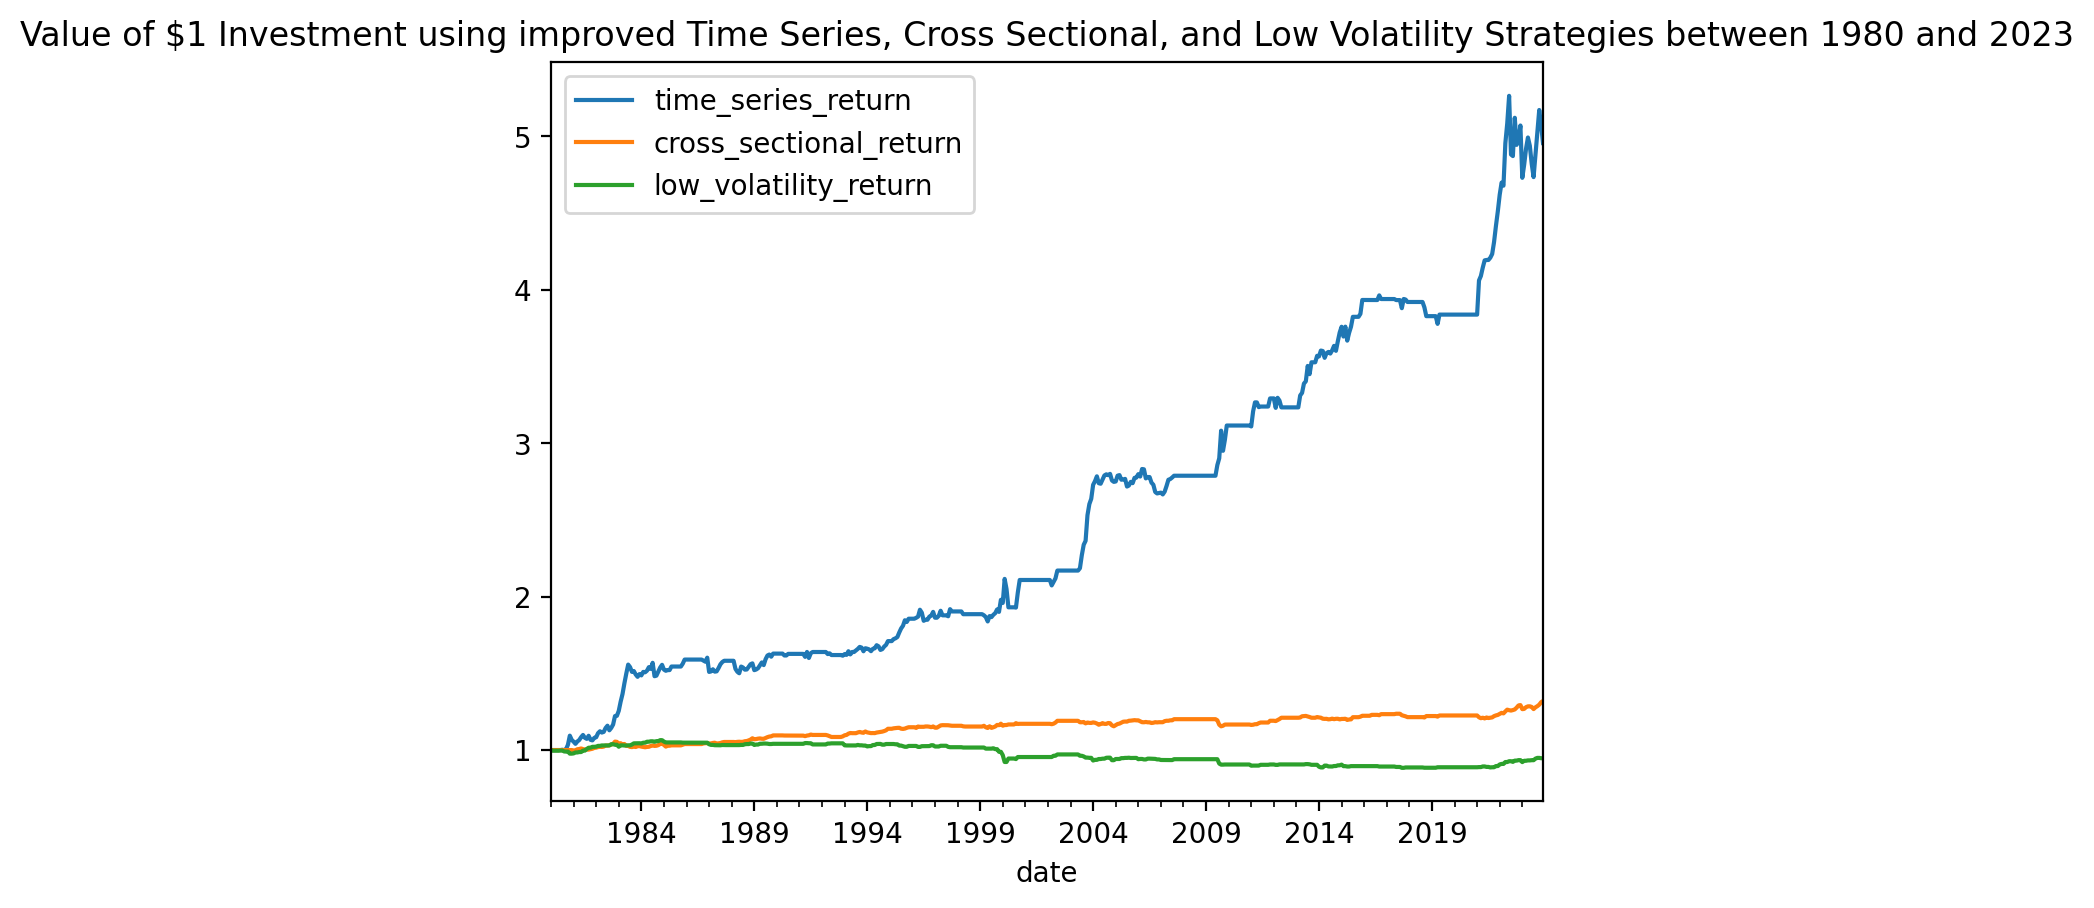

In [176]:
improved_performance_measures_table = pd.DataFrame(columns=performance_measures, index=['Time Series', 'Cross Sectional', 'Low Volatility'])
improved_performance_measures_table.index.name = 'Strategy'

improved_performance_measures_table['Average Monthly Return'] = find_improved_average_monthly_return()
improved_performance_measures_table['Monthly Standard Deviation'] = find_improved_monthly_standard_deviation()
improved_performance_measures_table['Annualized Sharpe Ratio'] = find_improved_annualized_sharpe_ratio()
improved_performance_measures_table['Maximum Drawdown'] = find_improved_maximum_drawdown()
improved_performance_measures_table['VaR(95%) - Historical'] = find_improved_var_historical()
improved_performance_measures_table['VaR(95%) - Parametric'] = find_improved_var_parametric()
improved_performance_measures_table['CVar(95%) - Historical'] = find_improved_cvar()
improved_performance_measures_table['Beta - CAPM'] = find_improved_beta()
improved_performance_measures_table['Alpha - FamaFrench 3'] = find_improved_alpha()

improved_cumulative_performance.plot()
plt.title('Value of $1 Investment using improved Time Series, Cross Sectional, and Low Volatility Strategies between 1980 and 2023')
improved_performance_measures_table

Since the performance of all of these funds is greater than what they were before making these changes, these improvements will greatly help these funds' performances.

# Part 3: Combining the Strategies

To create our fund, we have decided to implement the following strategy:

- For each month, only buy the stocks that have a “buy” signal according to at least 2 of the 3
strategies. Also, if any of the 3 strategies recommend a “sell” for a stock, it should not be bought.
- For each month, only short the stocks that have a “sell” signal according to at least 2 of the 3
strategies. Also, if any of the 3 strategies recommend a “buy” for a stock, it should not be bought

In [177]:
positions = df_monthly_positions.groupby(['date', 'permno'])[['position_time_series', 'position_cross_sectional', 'position_low_volatility']].first()

def determine_combined_positions(row):
    count_0 = (row == 0).sum()
    count_1 = (row == 1).sum()
    count_negative_1 = (row == -1).sum()

    if count_1 > count_0 and count_1 > count_negative_1:
        return 1
    elif count_negative_1 > count_0 and count_negative_1 > count_1:
        return -1
    else:
        return 0

positions['position_combined'] = positions.apply(determine_combined_positions, axis=1)

In [178]:
df_monthly_positions.head()

,date,permno,prc,ret,mcap,position_time_series,rolling_avg,position_cross_sectional,position_low_volatility,time_series_return,cross_sectional_return,low_volatility_return
0,1986-02-28,10003,22.250,0.011,42275.000,0,0.000,0,0,0.000,0.000,0.000
1,1986-03-31,10003,22.000,-0.011,41800.000,0,0.000,0,0,-0.000,-0.000,-0.000
2,1986-04-30,10003,20.625,-0.062,39187.500,0,0.000,0,0,-0.000,-0.000,-0.000
3,1986-05-31,10003,20.500,-0.006,44792.500,0,0.000,0,0,-0.000,-0.000,-0.000
4,1986-06-30,10003,21.750,0.061,47523.750,0,0.000,0,0,0.000,0.000,0.000


In [179]:
# Creating a DataFrame for combined performance by copying monthly stock returns and extracting the 'ret' column
combined_performance = df_monthly_stock_returns.copy()[['ret']]

# Calculating combined return by multiplying positions from 'positions' DataFrame with monthly stock returns
combined_performance['Combined Return'] = positions['position_combined'] * combined_performance['ret']

# Grouping by date and calculating the mean of the combined return
combined_performance = combined_performance.groupby('date').mean()[['Combined Return']]

# Multiplying the combined return with overlay positions from crossover_overlay DataFrame
combined_performance['combined return with overlay'] = combined_performance['Combined Return'] * crossover_overlay['positions']

In [180]:
# Calculating cumulative returns for combined performance by adding 1 and taking the cumulative product
combined_performance_cummulative_returns = combined_performance.add(1).cumprod()

In [181]:
def find_combined_average_monthly_return():
    combined_average = combined_performance['combined return with overlay'].mean()
    return [combined_average]

def find_combined_monthly_standard_deviation():
    combined_std = combined_performance['combined return with overlay'].std()
    return [combined_std]

def find_combined_annualized_sharpe_ratio():
    combined_annualized_sharpe_ratio = ((combined_performance['combined return with overlay'] - rf['RF']).mean()*12) / ((combined_performance['combined return with overlay'] - rf['RF']).std()*np.sqrt(12))
    return [combined_annualized_sharpe_ratio]

def find_combined_maximum_drawdown(): # project instructions don't specify all-time or some rolling lookback period for the drawdown calculation, default to all-time
    window = combined_performance_cummulative_returns.shape[0]

    combined_Rolling_Peak = combined_performance_cummulative_returns.rolling(window, min_periods=1).max()
    combined_Monthly_Drawdown = combined_performance_cummulative_returns/combined_Rolling_Peak - 1.0
    combined_Max_Monthly_Drawdown = combined_performance_cummulative_returns.rolling(window, min_periods=1).min()
    return [combined_Max_Monthly_Drawdown['combined return with overlay'].min()]

def find_combined_var_historical():
    confidence = 0.95
    combined_hVaR = np.percentile(combined_performance['combined return with overlay'].dropna(), 100 * (1-confidence))
    return [combined_hVaR]

def find_combined_var_parametric():
    confidence = 0.95
    norm = scipy.stats.norm
    combined_pVaR = norm.ppf(1-confidence, combined_performance['combined return with overlay'].mean(), combined_performance['combined return with overlay'].std())
    return [combined_pVaR]

def find_combined_cvar():
    confidence = 0.95

    combined_CVaR = np.mean(combined_performance['combined return with overlay'].dropna()[combined_performance['combined return with overlay'].dropna()<np.percentile(combined_performance['combined return with overlay'].dropna(), 100 * (1-confidence))])
    return [combined_CVaR]

def find_combined_beta():
    combined_capm_temp = rf.copy()
    combined_capm_temp['Combined-RF'] = combined_performance['combined return with overlay'] - rf['RF']

    combined_cov = combined_capm_temp[['Combined-RF','Mkt-RF']].cov()

    combined_beta =  combined_cov.loc['Combined-RF','Mkt-RF']/ combined_cov.loc['Mkt-RF','Mkt-RF']
    return [combined_beta]

def find_combined_alpha():
    combined_ff3_temp = rf.copy()
    combined_ff3_temp['Combined-RF'] = combined_performance['combined return with overlay'] - rf['RF']

    X = sm.add_constant(combined_ff3_temp[['Mkt-RF','SMB','HML']])

    combined_ff3 = sm.OLS(combined_ff3_temp['Combined-RF'], X, missing = 'drop').fit()
    return [combined_ff3.params.iloc[0]]

In [182]:
combined_performance_measures_table = pd.DataFrame(columns=performance_measures, index=['Combined'])
combined_performance_measures_table.index.name = 'Strategy'

combined_performance_measures_table['Average Monthly Return'] = find_combined_average_monthly_return()
combined_performance_measures_table['Monthly Standard Deviation'] = find_combined_monthly_standard_deviation()
combined_performance_measures_table['Annualized Sharpe Ratio'] = find_combined_annualized_sharpe_ratio()
combined_performance_measures_table['Maximum Drawdown'] = find_combined_maximum_drawdown()
combined_performance_measures_table['VaR(95%) - Historical'] = find_combined_var_historical()
combined_performance_measures_table['VaR(95%) - Parametric'] = find_combined_var_parametric()
combined_performance_measures_table['CVar(95%) - Historical'] = find_combined_cvar()
combined_performance_measures_table['Beta - CAPM'] = find_combined_beta()
combined_performance_measures_table['Alpha - FamaFrench 3'] = find_combined_alpha()

combined_performance_measures_table

,Average Monthly Return,Monthly Standard Deviation,Annualized Sharpe Ratio,Maximum Drawdown,VaR(95%) - Historical,VaR(95%) - Parametric,CVar(95%) - Historical,Beta - CAPM,Alpha - FamaFrench 3
Strategy,,,,,,,,,
Combined,0.001,0.005,-1.713,0.992,-0.005,-0.007,-0.012,-0.012,-0.003


In [183]:
# Get QRPNX data from Yahoo Finance

# Define start and end dates
START_DATE = dt.datetime(2018, 1, 1)
END_DATE = dt.datetime(2023, 12, 31)

# Download QRPNX adjusted close prices from Yahoo Finance and select 'Adj Close' column
df_qrpnx = yf.download(['QRPNX'], START_DATE, END_DATE)[['Adj Close']]

# Calculate monthly returns from adjusted close prices, drop NaN values, and resample to monthly frequency
df_qrpnx_rets = df_qrpnx.pct_change().dropna().resample(rule='M').apply(lambda x: x.add(1).prod().sub(1))

# Resample adjusted close prices to monthly frequency and select last value of each month
df_qrpnx_prices = df_qrpnx.dropna().resample(rule='M').last()


[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Value of $1 Investment using our Fund vs QRPNX')

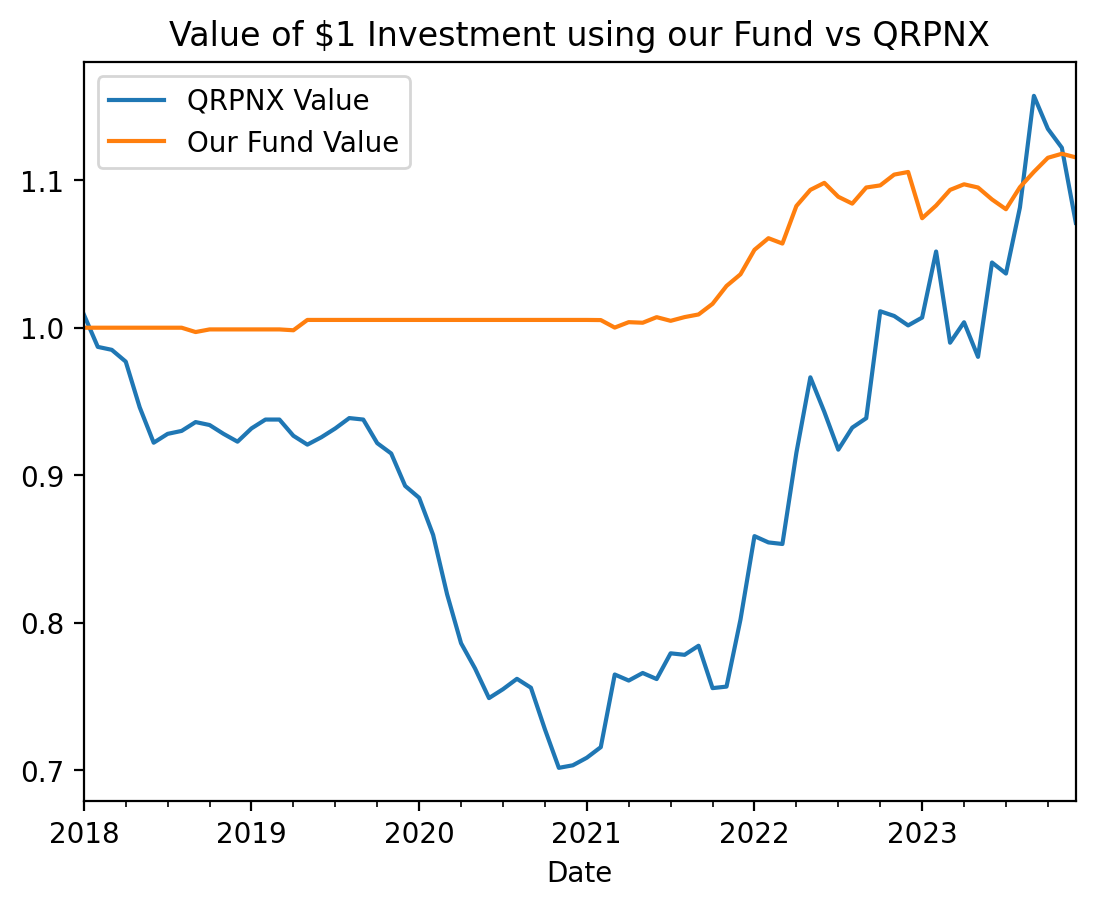

In [184]:
# Show graph with value of $1 investment of both our fund and QRPNX

# Calculate the adjusted fund value starting from START_DATE and taking cumulative product
adjusted_fund = combined_performance[START_DATE:].add(1).cumprod()

# Merge adjusted fund values with QRPNX cumulative returns
combined_returns_with_qrpnx = pd.merge(adjusted_fund, df_qrpnx_rets.add(1).cumprod(), left_index=True, right_index=True)[['Adj Close', 'combined return with overlay']]

# Rename columns for clarity
combined_returns_with_qrpnx.rename(columns={'Adj Close': "QRPNX Value", 'combined return with overlay': 'Our Fund Value'}, inplace=True)

# Plot the values
combined_returns_with_qrpnx.plot()

# Set labels and title
plt.xlabel('Date')
plt.title('Value of $1 Investment using our Fund vs QRPNX')


Over the course of this period, our fund out performed QRPNX and was less volatile.

# Part 4

In [185]:
#Task 1: Find the correlation between the monthly return of your fund and the return of this potential client’s fund from year 2000 onward

spy_ticker = 'SPY'
start_date = '2000-01-01'
end_date = '2024-04-23'

# Fetch historical data
spy_data = yf.download(spy_ticker, start=start_date, end=end_date)

# Extract 'Close' prices and calculate returns
spy_etf_returns_daily = spy_data['Close'].pct_change().dropna()

# Resample SPY ETF returns to monthly frequency
spy_etf_returns_monthly = spy_etf_returns_daily.resample('M').sum()

# Filter combined performance returns data from year 2000 onward
combined_performance_returns_from_2000 = combined_performance.loc['2000-01-01':]

# Calculate correlation between combined performance returns and SPY ETF returns
correlation = combined_performance_returns_from_2000['combined return with overlay'].corr(spy_etf_returns_monthly)
print("\nCorrelation between your fund and the SPY ETF from year 2000 onward (monthly):", correlation)

[*********************100%%**********************]  1 of 1 completed


Correlation between your fund and the SPY ETF from year 2000 onward (monthly): -0.19273718233935705


In [186]:
# Task 2: Find the optimal weight associated with your fund in a portfolio that consists of your fund and the S&P500 index ETF.

import scipy.optimize as sciopt

# Calculate excess returns
our_fund_excess_returns = combined_performance - rf['RF'].mean()
spy_excess_returns = spy_etf_returns_monthly - rf['RF'].mean()

# Concatenate excess returns into a single DataFrame
excess_returns = pd.concat([our_fund_excess_returns, spy_excess_returns], axis=1)[['combined return with overlay', 'Close']]

# Define optimization period
start_date = '2000-01-01'
end_date = '2024-04-23'
ETF_returns_optimization = excess_returns.loc[start_date:end_date]

num_assets = len(ETF_returns_optimization.columns)

# Function to calculate negative Sharpe ratio for optimization
def neg_sharpe_ratio(weights, returns):
    mean_return = np.sum(returns.mean() * weights) * 12
    std_deviation = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 12, weights)))
    sharpe_ratio = mean_return / std_deviation
    return -sharpe_ratio

# Equality constraint: sum of weights equals 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for each asset's weight: between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess for weights: equal weight for each asset
initial_guess = num_assets * [1. / num_assets]

# Optimization to find optimal weights
optimal_weights = sciopt.minimize(neg_sharpe_ratio, initial_guess,
                                   args=(ETF_returns_optimization,),
                                   method='SLSQP', bounds=bounds, constraints=constraints)

# Extracting optimal weights
optimal_weights = optimal_weights.x

# Rounding optimal weights for readability
optimal_weights_rounded = np.round(optimal_weights, 4)

# Creating DataFrame to store optimal weights
weights = pd.DataFrame(optimal_weights_rounded, index=ETF_returns_optimization.columns, columns=['OptimalWeights'])


# Rename assets
asset_names = {
    'Combined Return': 'Our Fund',
    'Close': 'S&P500 ETF'
}
weights.rename(index=asset_names, inplace=True)

print("Optimal Weights:", weights)

Optimal Weights:                               OptimalWeights
combined return with overlay           0.000
S&P500 ETF                             1.000


While our fund is less volitile than the SP500, the returns are significantly lower and the risk associated with the SP500 is made up for with its returns compared to our fund, which is why the optimal weight is for all investment to be in the SP500.

In [187]:
# Compare the risk adjusted performance of the optimal portfolio that consists of your fund and
# the S&P500 ETF with a portfolio that consists of only the S&P500 ETF

# Calculate annualized returns and standard deviations for both portfolios
portfolio_returns = ETF_returns_optimization[:"2023-12-31"].dot(optimal_weights)
portfolio_std = portfolio_returns.std()

sharpe_ratio_optimal = (((portfolio_returns).mean() * 12) / (portfolio_std * np.sqrt(12)))

returns_sp500 = ETF_returns_optimization[:'2023-12-31']['Close']
std_sp500 = returns_sp500.std()
mean_sp500 = returns_sp500.mean()
sharpe_ratio_sp500 = (mean_sp500 * 12) / (std_sp500 * np.sqrt(12))

print("Sharpe Ratio (Optimal Portfolio):", sharpe_ratio_optimal)
print("Sharpe Ratio (S&P500 ETF Portfolio):", sharpe_ratio_sp500)

Sharpe Ratio (Optimal Portfolio): 0.19343874139898493
Sharpe Ratio (S&P500 ETF Portfolio): 0.193438741398985


Since the optimal portoflio has all of our investment in the SP500, the sharpe ratio is the same as the sharpe ratio of the SP500. The underperformance of the risk free rate was a large factor which resulted in our fund being beat by the SP500.